### This notebook aims to provide a deeper dive into which features are important in helping predict models.
### We will also be performing feature engineering techniques in order to improve model performance

In [1]:
import pandas as pd
import numpy as np
from scripts.datacleaningutils import datacleaning
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

C:\Users\maxwe\AppData\Local\Temp\ipykernel_5228\984889995.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("data/cleaned.csv")
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

In [3]:
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,2013.0,3.0,1.0,0.0,6.00,8.25,6.25,14.25,275.0,81.00,-0.550,1024.125,-20.750,0.0,5.375,NNW
1,2013.0,3.0,1.0,1.0,5.50,12.25,6.75,14.00,275.0,81.00,-0.800,1024.625,-21.125,0.0,4.100,NW
2,2013.0,3.0,1.0,2.0,4.75,5.50,7.25,15.50,275.0,71.75,-1.175,1024.850,-23.000,0.0,5.375,NNW
3,2013.0,3.0,1.0,3.0,4.25,5.00,5.25,17.00,325.0,70.50,-1.400,1025.775,-23.975,0.0,4.450,N
4,2013.0,3.0,1.0,4.0,4.00,4.75,6.25,16.00,300.0,75.50,-1.925,1026.625,-23.250,0.0,2.900,NNW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,15.75,39.25,2.75,30.25,425.0,69.50,12.500,1013.500,-16.200,0.0,2.400,NW
35060,2017.0,2.0,28.0,20.0,16.75,37.25,3.25,41.00,475.0,52.50,11.600,1013.600,-15.100,0.0,0.900,WNW
35061,2017.0,2.0,28.0,21.0,18.00,40.50,4.75,49.50,575.0,41.75,10.800,1014.200,-13.300,0.0,1.100,NW
35062,2017.0,2.0,28.0,22.0,15.00,38.50,6.25,55.75,625.0,35.25,10.500,1014.400,-12.900,0.0,1.200,NNW


### Recall that our data is proven to be skewed in our EDA portion of the project
We will plot a kde matrix to reiterate this issue

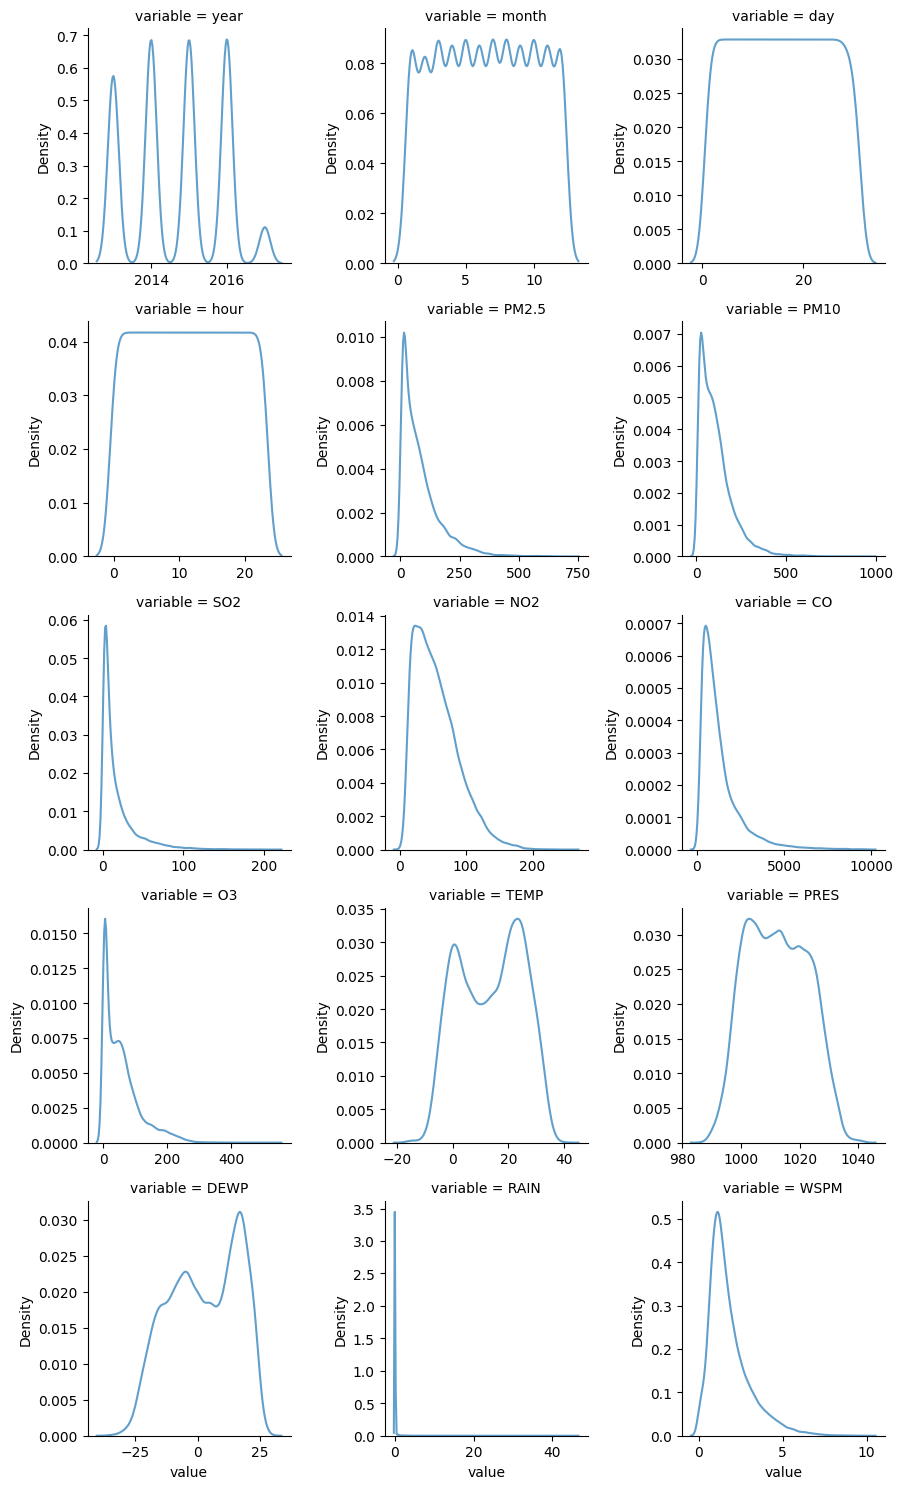

In [4]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# melt df
melted_df = pd.melt(df, value_vars=numerical_columns.columns)

# use sns facet for kde
g = sns.FacetGrid(melted_df, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', alpha=0.7)
g.add_legend()
plt.show()

In [5]:
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

def print_skew(df, numeric_columns, filter=True):
    numeric_df = df[numeric_columns]
    skewed_cols = []
    # Calculate skewness
    skew_values = numeric_df.skew()
    print("Skewed values:")
    for i in range(len(skew_values)):
        if abs(skew_values.values[i]) > 0.6 or not filter:
            print(f"{skew_values.index[i]} :  {skew_values.values[i]}")
            skewed_cols.append(skew_values.index[i])
    return skewed_cols

skewed_cols = print_skew(df,numeric_columns, True)

Skewed values:
PM2.5 :  1.9430598625750046
PM10 :  1.8806887563244385
SO2 :  2.6185915611409176
NO2 :  0.9645048524019495
CO :  2.4404598409443117
O3 :  1.4619928300095857
RAIN :  27.606606048748002
WSPM :  1.5160277339355892


What a shocker... Our dataset is greatly skewed. In particular, RAIN is a column that shows significant skew. This could mean that this particular area (of 4 districts mentioned) rains very rarely. Let's check the value counts to confirm this.

In [6]:
rain_zero_count = (df['RAIN'] == 0).sum()
total_length = len(df)
ratio = rain_zero_count / total_length
print(f"Proportion of non-rainy hours {ratio}")

Proportion of non-rainy hours 0.9562514259639516


### Due to the nature of our business problem, we cannot just "drop" rows with outlying values.
Instead, we will try to "unskew" the data by employing
1. Logaritmic Transformation <a href="[./scripts/datatransformations.py](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9#:~:text=What%20is%20Log%20Transformation%3F,the%20purposes%20of%20statistical%20modeling.)">link</a>
2. Square Root Transformation <a href="https://quantifyinghealth.com/square-root-transformation/">link</a>
3. Yeo Johnson Transformation <a href="https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/">link</a>

Source code can be found in <a href="./scripts/datatransformations.py">./scripts/datatransformations.py</a>

In [7]:
skewed_cols

['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'RAIN', 'WSPM']

In [8]:
from scripts.datatransformations import datatransformation
trans = datatransformation()

df_yj, l = trans.yeojohnson_transform_columns(df,skewed_cols)
df_sqrt = trans.sqrt_transform_column(df,skewed_cols)
df_log = trans.log_transform_columns(df,skewed_cols)

In [10]:
l

{'PM2.5': 0.11821580362920309,
 'PM10': 0.18947730848393513,
 'SO2': -0.2404703077191753,
 'NO2': 0.22404372458954563,
 'CO': -0.10109070447505275,
 'O3': 0.1970739743881009,
 'RAIN': -36.75122189560069,
 'WSPM': -0.29073179806681426}

In [9]:
skew_yj = df_yj[skewed_cols].skew()
skew_sqrt = df_sqrt[skewed_cols].skew()
skew_log = df_log[skewed_cols].skew()
# Create a DataFrame to store skew values
skew_df = pd.DataFrame({
    'Original': df[skewed_cols].skew(),
    'Ye-Johnson': skew_yj,
    'Square Root': skew_sqrt,
    'Log': skew_log
})

# Display the skew values table
print(skew_df)

        Original  Ye-Johnson  Square Root        Log
PM2.5   1.943060   -0.033029     0.714755  -0.251373
PM10    1.880689   -0.030515     0.601139  -0.404214
SO2     2.618592    0.089058     1.282976   0.428573
NO2     0.964505   -0.030265     0.302386  -0.314834
CO      2.440460    0.012595     1.183055   0.191088
O3      1.461993   -0.088447     0.438930  -0.418825
RAIN   27.606606    4.511358    10.197139  10.015784
WSPM    1.516028    0.002608     0.411028   0.332779


We can see that the skew has significantly decreased. This could potentially allow machine learning models to perform better. Hoewever, we would still need to run experiments to actually test it out

Let's plot the correlation heat map for the newly transformed data

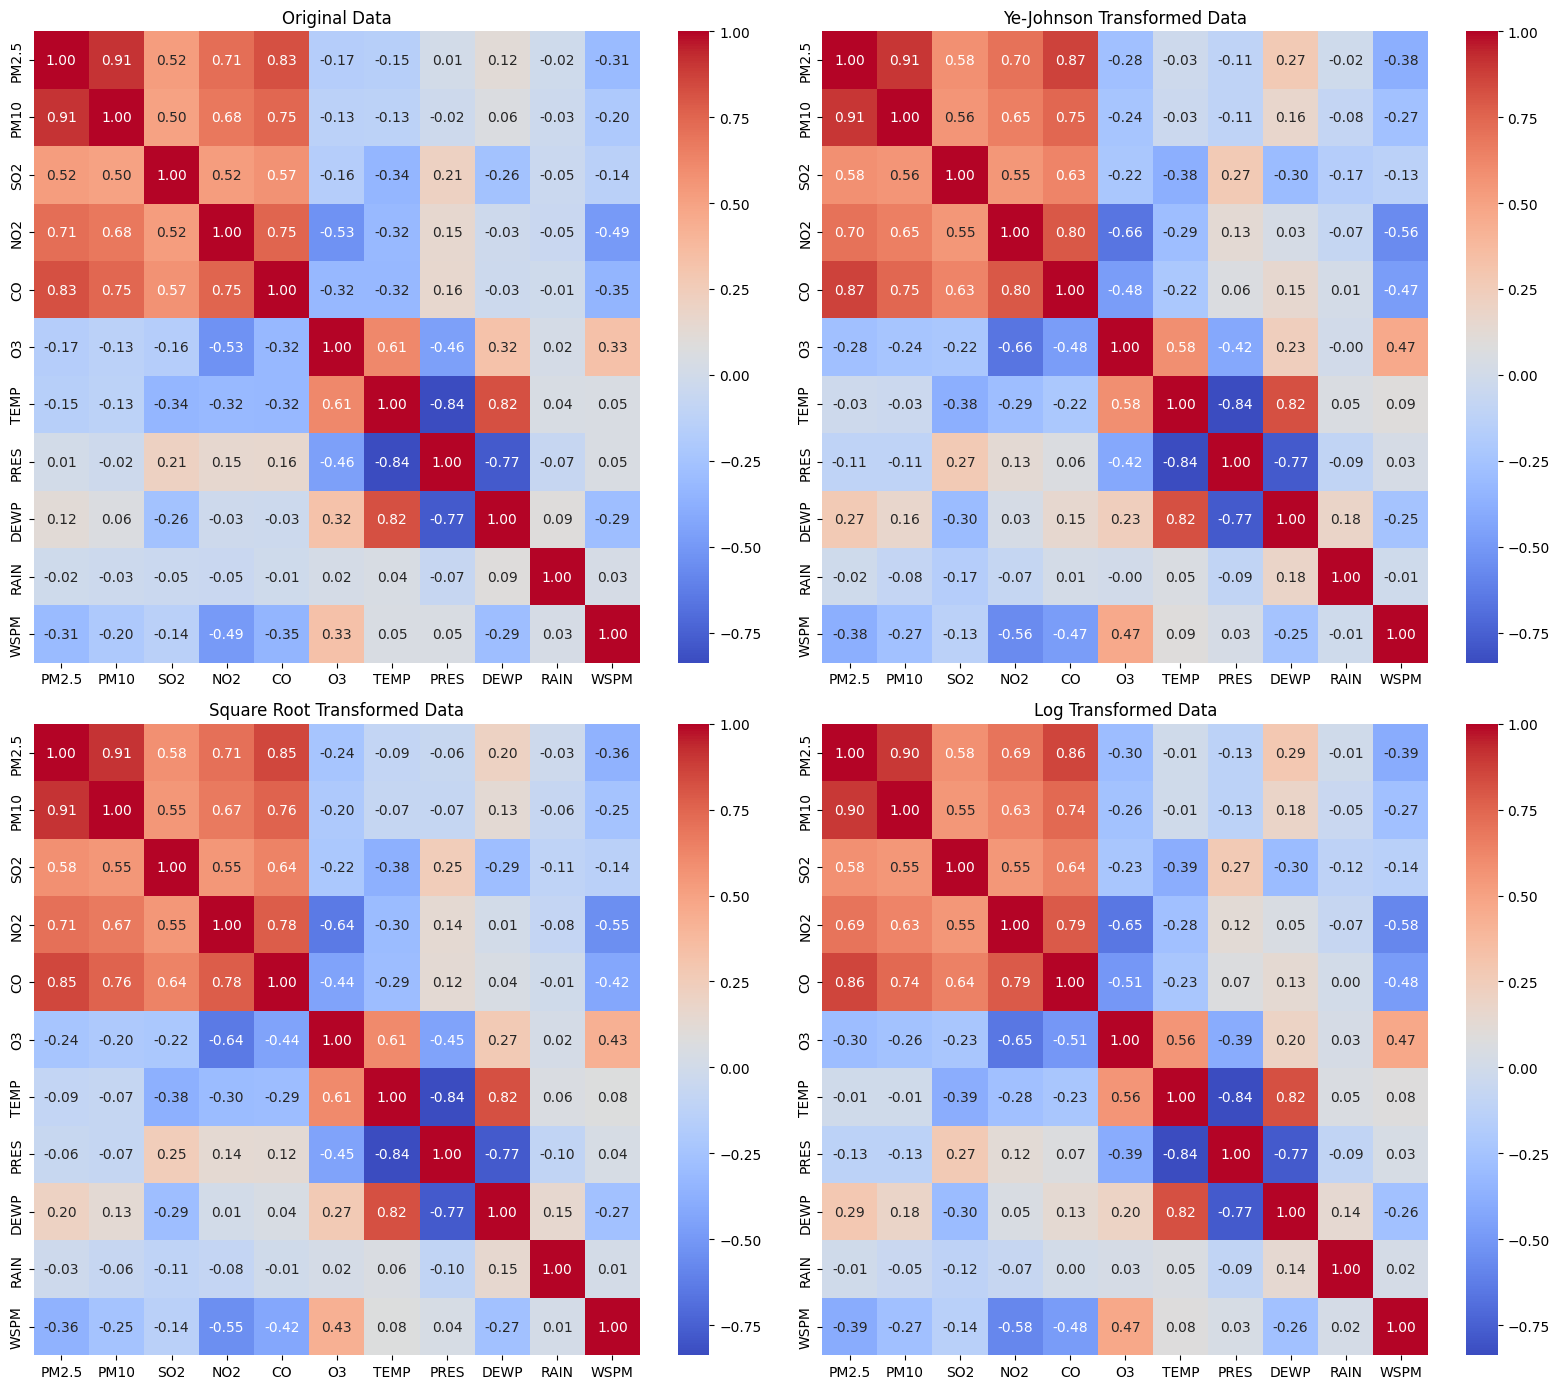

In [23]:
corr_original = df[numeric_columns].corr()
corr_yj = df_yj[numeric_columns].corr()
corr_sqrt = df_sqrt[numeric_columns].corr()
corr_log = df_log[numeric_columns].corr()

# Plot heatmaps side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Original DataFrame
sns.heatmap(corr_original, ax=axes[0][0], cmap="coolwarm", annot=True, fmt=".2f")
axes[0][0].set_title('Original Data')

# Ye-Johnson transformed DataFrame
sns.heatmap(corr_yj, ax=axes[0][1], cmap="coolwarm", annot=True, fmt=".2f")
axes[0][1].set_title('Ye-Johnson Transformed Data')

# Square Root transformed DataFrame
sns.heatmap(corr_sqrt, ax=axes[1][0], cmap="coolwarm", annot=True, fmt=".2f")
axes[1][0].set_title('Square Root Transformed Data')

# Log transformed DataFrame
sns.heatmap(corr_log, ax=axes[1][1], cmap="coolwarm", annot=True, fmt=".2f")
axes[1][1].set_title('Log Transformed Data')

plt.tight_layout()
plt.show()

Seems like our transformations did not affect the correlations much.

From our EDA in our previous notebooks, we have already concluded that 'PM10', 'SO2', 'NO2', 'CO', 'O3' were the top predictors. However, we can see that after transforming the data, we can see that WSPM and DERP has increased correlations.

In [11]:
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
numeric_df = df[numeric_columns]
skewed_cols = []
# Calculate skewness
skew_values = numeric_df.skew()
print("Skewed values:")
for i in range(len(skew_values)):
    if abs(skew_values.values[i]) > 0.6:
        print(f"{skew_values.index[i]} :  {skew_values.values[i]}")
        skewed_cols.append(skew_values.index[i])

Skewed values:
PM2.5 :  1.9430598625750046
PM10 :  1.8806887563244385
SO2 :  2.6185915611409176
NO2 :  0.9645048524019495
CO :  2.4404598409443117
O3 :  1.4619928300095857
RAIN :  27.606606048748002
WSPM :  1.5160277339355892


### We have a column that stores the Wind Speed (WSPM) showing a moderate-weak correlation
But does the wind direction (wd) have any affect on PM2.5?

We hypothesize that wind direction combined with wind speed can create a feature that is more meaningful in making predictions.

There is also no good way to encode wind direction

Below is a plot of wind directions in the columns and their respective angles

### To incorporate wind direction and windspeed into a single feature, we will take the orthogonal projection w.r.t. a reference vector 
  
<img src="img/orthogonal.png" height=200> <a href="https://textbooks.math.gatech.edu/ila/projections.html"><br>link to book here</a></img>

- In order to make this usable for our usecase, we need to manipulate the equation
- For any 2 vectors, A, B, A.B can be expressed as |A||B|cos(c), where c is the angle between A and B
- Knowing that we have the angles as defined by wind direction, c can be eaily computed
- ((u.x)/(u.u))u = (u.x)u', whereby u' is the unit vector of u
- (u.x)u' = |u||x|cos(c)u'
- given that u is our orthonormal basis, we can simplify the formula into
- projection = |x|cos(c) u'
- since we are only interested in the magnitude of the orthogonal projection w.r.t. u',
- projection_magnitude = |x|cos(c)
- This can be utilized by applying the following formula
```
wind_speed_projection = wind_speed * np.cos(np.radians(wind_direction_deg - reference_direction_deg)) #windspeed always non-negative
```
- Source code available in <a href="./scripts/datatransformations.py">./scripts/datatransformations.py</a>
- To help visualize, I have plotted a diagram of wind directions for reference.
- I will iterate thru all possible directions to get the reference vector that has the best correlation with PM2.5

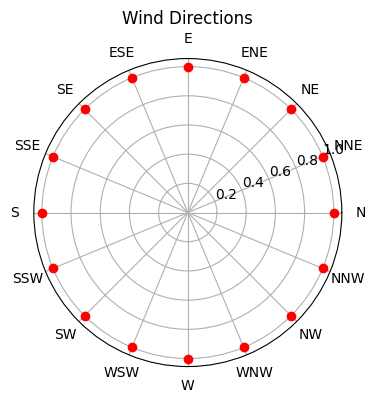

In [12]:
wind_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                   'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
angular_positions = np.arange(0, 360, 22.5)

# Plot wind directions
plt.figure(figsize=(4, 4))
plt.polar(np.radians(angular_positions), np.ones_like(angular_positions), 'ro')
plt.thetagrids(angles=np.degrees(np.radians(angular_positions)), labels=wind_directions)
plt.title('Wind Directions')
plt.show()

In [13]:
# iteratively calculate projection vector w.r.t all directions, retrieve the most correlated direction
df_arr = [df,df_yj,df_sqrt,df_log]
labels = ['org', 'yj', 'sqrt', 'log']
wind_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                   'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

for d in range(len(df_arr)):
    maximum = 0
    max_label = ""
    for i in wind_directions:
        df_arr[d]['projection'] = df_arr[d].apply(lambda row: trans.calculate_projection_vector(row, i), axis=1)
        # print(i,df['projection'].corr(df['PM2.5']))
        if abs(df_arr[d]['projection'].corr(df_arr[d]['PM2.5'])) > maximum:
            maximum = df_arr[d]['projection'].corr(df_arr[d]['PM2.5'])
            max_label = i
    print(f"Correlation result for {labels[d]}: {max_label} {maximum} has the strongest correlation")

Correlation result for org: SE 0.27556363954416985 has the strongest correlation
Correlation result for yj: SE 0.4247263560401358 has the strongest correlation
Correlation result for sqrt: SE 0.3704919962532667 has the strongest correlation
Correlation result for log: SE 0.4417824429195834 has the strongest correlation


It seems like there is moderate correlation for the yj, log, org and log. Despite this, we still feel that this new feature is important as the direction of the wind along with windspeed matters. There could be a factory nearby that spits fumes out in a certain wind direction. We hence feel that this could provide useful insight to the data, especially in non-linear models like Deep Neural Networks

We will now remove wind direction (wd) from the dataframe, and use projection in it's place, while still keeping windspeed as a feature

In [14]:
df = df.drop(['wd'], axis=1)
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,projection
0,2013.0,3.0,1.0,0.0,6.00,8.25,6.25,14.25,275.0,81.00,-0.550,1024.125,-20.750,0.0,5.375,5.375000
1,2013.0,3.0,1.0,1.0,5.50,12.25,6.75,14.00,275.0,81.00,-0.800,1024.625,-21.125,0.0,4.100,3.787906
2,2013.0,3.0,1.0,2.0,4.75,5.50,7.25,15.50,275.0,71.75,-1.175,1024.850,-23.000,0.0,5.375,5.375000
3,2013.0,3.0,1.0,3.0,4.25,5.00,5.25,17.00,325.0,70.50,-1.400,1025.775,-23.975,0.0,4.450,4.111264
4,2013.0,3.0,1.0,4.0,4.00,4.75,6.25,16.00,300.0,75.50,-1.925,1026.625,-23.250,0.0,2.900,2.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,15.75,39.25,2.75,30.25,425.0,69.50,12.500,1013.500,-16.200,0.0,2.400,2.217311
35060,2017.0,2.0,28.0,20.0,16.75,37.25,3.25,41.00,475.0,52.50,11.600,1013.600,-15.100,0.0,0.900,0.636396
35061,2017.0,2.0,28.0,21.0,18.00,40.50,4.75,49.50,575.0,41.75,10.800,1014.200,-13.300,0.0,1.100,1.016267
35062,2017.0,2.0,28.0,22.0,15.00,38.50,6.25,55.75,625.0,35.25,10.500,1014.400,-12.900,0.0,1.200,1.200000


In [15]:
for d in range(len(df_arr)):
    df_arr[d] = df_arr[d].drop(['wd'], axis=1)

### We will now conduct PCA to determine each feature's importance.

We followed the steps that are outlines in <a href="https://builtin.com/data-science/step-step-explanation-principal-component-analysis">this</a>

PCA source code can be accessed in <a href="./scripts/datatransformations.py">./scripts/datatransformations.py</a>

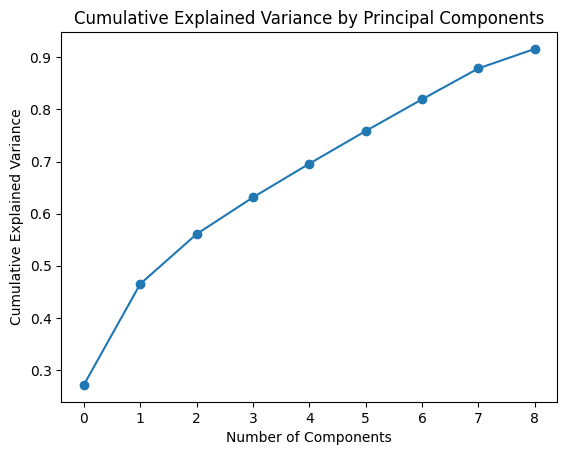

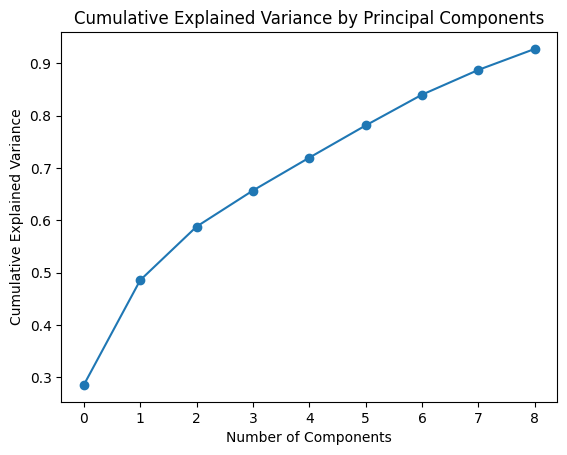

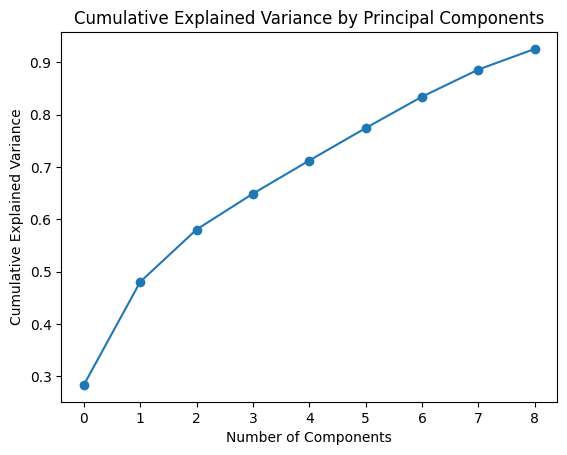

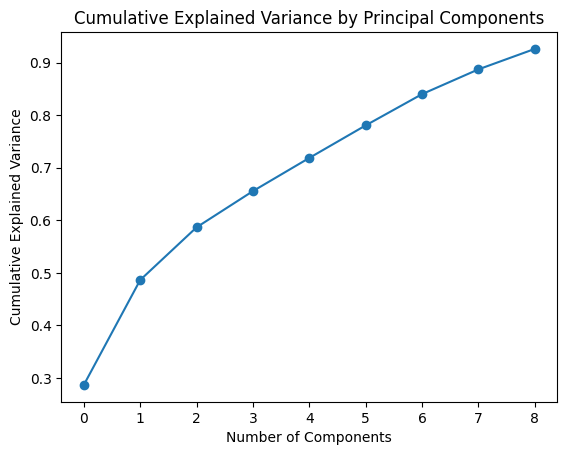

In [16]:
components = []
for d in df_arr:
    components.append(trans.conduct_pca(d))
    # the conduct_pca method returns the number of times each featre appears in ALL components

In [17]:
tbl = pd.DataFrame.from_dict(components)
tbl.index = labels
tbl

,PM10,SO2,WSPM,hour,projection,PRES,month,year,day,O3,RAIN,PM2.5,NO2,TEMP,DEWP,CO
org,7,7,7,7,6,5,5,5,5,4,4,3,2,2.0,2,NaN
yj,4,5,6,5,8,5,7,7,3,4,5,3,2,3.0,2,3.0
sqrt,4,7,7,5,7,4,6,7,3,4,5,4,2,2.0,3,2.0
log,4,6,7,6,8,5,6,7,3,4,5,3,2,NaN,3,2.0


From our PCA, we observe than the columns 

- PM10	
- SO2	
- WSPM	
- hour	
- projection	
- PRES	
- month	
- year	
- day	
- O3	
- RAIN
  
Have apeared the most frequently in our components, indicating that it could be important features for a model within this dataset.

As projection (reference direction SE) pops up in this frequency table (derived from the number of times each feature appears in each principle component), it supports our argument that incorporating wind direction and windspeed into the orthogonal projection that it can explain the variance **in this dataset (not just w.r.t PM2.5)**. This is further supported by base feature (windspeed) appearing in the frequency table.

Most shockingly, rain and PRES also has some significance according to the frequency table, hence we can choose to include it as a feature in our predictive models. It could indicate that there could be clusters that could potentially affect the the overall dataset (not just PM2.5)

To conclude:
We have found our top predictors.

``feature_names = ['PM10', 'SO2', 'WSPM', 'hour', 'projection', 'PRES', 'month', 'year', 'day', 'O3', 'RAIN']``

We can proceed to create our models